## Imports

Imports every library needed

In [1]:
#general imports
import math

import pandas as pd
import numpy as np

#statsmodels for regression
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.iolib.summary2 import summary_col

#scipy for testing
from scipy import stats

#for visualization
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

## Importing the Bike Data

Imports the normal Data needed for every KPI

In [2]:
df_bikes = pd.read_csv('../data/philadelphia_2017.csv')
df_weather = pd.read_csv('../data/weather_hourly_philadelphia.csv')
df_geocodes = pd.read_csv('../data/geocodes.csv')

def get_datetime(date_string):
    if date_string.__contains__("/"):
        new_string = ""
        running_string = ""
        for char in date_string:
            if char == "/" or  char == ":" or char == " ":
                if len(running_string) == 1:
                    running_string = "0" + running_string
                new_string += running_string + char
                running_string = ""
            else:
                running_string += char
        new_string += running_string
        if len(new_string) > 16:
            return datetime.strptime(new_string, '%m/%d/%Y %H:%M:%S')
        else:
            return datetime.strptime(new_string, '%m/%d/%Y %H:%M')
    else:
        return datetime.fromisoformat(date_string)

def compare_datetime(start, end):
    start_datetime = get_datetime(start)
    end_datetime = get_datetime(end)
    duration_of_travel = end_datetime - start_datetime
    seconds = duration_of_travel.total_seconds()
    return seconds/60

ride_lengths = []
df_bikes["ride_duration_minutes"] = df_bikes.apply(lambda x: (compare_datetime(x["start_time"],x["end_time"])), axis=1)

for label, content in df_bikes.iterrows():
    ride_lengths.append(content["ride_duration_minutes"])

ride_lengths_np = np.array(ride_lengths)
iqr = stats.iqr(ride_lengths_np)
iqr

q1,q3 = np.percentile(ride_lengths_np, [25,95])

lower_range = q1 - (1.5*iqr)
upper_range = q3 + (1.5*iqr)

#A ride, can't be shorter than 0 Minutes obviously
if lower_range < 0:
    lower_range = 0

df_bikes.drop(df_bikes[ (df_bikes.ride_duration_minutes > upper_range) | (df_bikes.ride_duration_minutes < lower_range) ].index , inplace=True)


## Description
Total distance driven by all drivers within one hour

#### ToDo:
https://www.kompf.de/gps/distcalc.html bessere Mathode implimentieren.

In [3]:
def calc_distance(start_lat, start_lng, end_lat, end_lng):
    dx = 111.3 * (end_lat - start_lat)
    dy = 71.5 * (end_lng - start_lng)
    distance = math.sqrt(dx * dx + dy * dy)
    return distance

In [4]:
df_bikes.head(10)

,start_time,end_time,start_station_id,end_station_id,bike_id,user_type,start_station_name,end_station_name,ride_duration_minutes
0,1/1/2017 0:05,1/1/2017 0:16,3046,3041,5347,Indego30,2nd & Market,"Girard Station, MFL",11.0
1,1/1/2017 0:21,1/1/2017 0:57,3110,3054,3364,Walk-up,Del. River Trail & Penn St.,Rodin Museum,36.0
2,1/1/2017 0:22,1/1/2017 0:57,3110,3054,2536,Walk-up,Del. River Trail & Penn St.,Rodin Museum,35.0
3,1/1/2017 0:27,1/1/2017 0:39,3041,3005,5176,Indego30,"Girard Station, MFL","Welcome Park, NPS",12.0
4,1/1/2017 0:28,1/1/2017 0:36,3047,3124,5370,Walk-up,"Independence Mall, NPS",Race Street Pier,8.0
5,1/1/2017 0:29,1/1/2017 0:36,3047,3124,2479,Walk-up,"Independence Mall, NPS",Race Street Pier,7.0
6,1/1/2017 0:31,1/1/2017 0:40,3072,3068,5332,Indego30,Front & Carpenter,Broad & Federal,9.0
7,1/1/2017 0:34,1/1/2017 0:50,3033,3114,5359,Indego30,10th & Chestnut,22nd & Federal,16.0
8,1/1/2017 0:38,1/1/2017 0:57,3013,3028,3716,Walk-up,6th & Fairmount,4th & Bainbridge,19.0
9,1/1/2017 0:40,1/1/2017 0:57,3013,3028,2557,Walk-up,6th & Fairmount,4th & Bainbridge,17.0


In [5]:
df_bikes.insert(4, 's_lat', df_bikes['start_station_id'].map(df_geocodes.set_index('station_id')['lat']))
df_bikes.insert(5, 's_lng', df_bikes['start_station_id'].map(df_geocodes.set_index('station_id')['lng']))
df_bikes.insert(7, 'e_lat', df_bikes['end_station_id'].map(df_geocodes.set_index('station_id')['lat']))
df_bikes.insert(8, 'e_lng', df_bikes['end_station_id'].map(df_geocodes.set_index('station_id')['lng']))

In [6]:
df_bikes.head(10)

df_bikes.dtypes

start_time                object
end_time                  object
start_station_id           int64
end_station_id             int64
s_lat                    float64
s_lng                    float64
bike_id                    int64
e_lat                    float64
e_lng                    float64
user_type                 object
start_station_name        object
end_station_name          object
ride_duration_minutes    float64
dtype: object

In [7]:
sample = np.linspace(1, 100, 763228).astype(int)

df_bikes["distance"] = df_bikes.apply(lambda x: calc_distance(x['s_lat'],x['s_lng'],x['e_lat'],x['e_lng']), axis=1)

In [8]:
df_bikes['end_time_rounded'] = get_datetime(df_bikes["end_time"][0]).replace(minute=0)

In [9]:
s = 0
z = 1
for x in range(0,788906):
    if x not in df_bikes.index:
        s = s + 1
        if s == 1000*z:
            print(x)
            z = z + 1
        else:
            pass
    else:
        df_bikes['end_time_rounded'][x] = get_datetime(df_bikes["end_time"][x]).replace(minute=0)

<ipython-input-9-68b4343a476b>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bikes['end_time_rounded'][x] = get_datetime(df_bikes["end_time"][x]).replace(minute=0)


45795
66133
108591
131887
155306
184846
217251
238406
268642
293197
321602
343296
369865
399242
432102
457399
487616
519325
541169
576939
607341
646208
677934
712174
758304


In [10]:
df_bikes0 = df_bikes
df_bikes1 = df_bikes

In [11]:
#df_bikes['end_time_rounded'] = df_bikes['end_time_rounded'].dt.strftime("%y/%m/%d %H:%M:%S")
df_bikes['end_time_rounded'] = df_bikes['end_time_rounded'].dt.strftime("%y/%m/%d %H")

In [12]:
df_bikes_distances = df_bikes.groupby(['end_time_rounded']).sum()

In [13]:
df_bikes_distances.drop(['start_station_id', 'end_station_id', 's_lat', 's_lng', 'e_lat', 'e_lng', 'bike_id', 'ride_duration_minutes'], axis=1)

,distance
end_time_rounded,
17/01/01 00,23.535024
17/01/01 01,42.886259
17/01/01 02,32.867972
17/01/01 03,9.861137
17/01/01 04,4.687468
...,...
17/12/31 19,20.422862
17/12/31 20,7.618619
17/12/31 21,6.540375


# Visualization

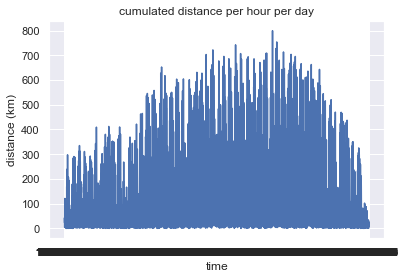

In [15]:
sns.set_theme(style="darkgrid")
# Plot the responses for different events and regions
distance_lineplot = sns.lineplot(x="end_time_rounded", y="distance", data=df_bikes_distances)
distance_lineplot.set_xlabel('time')
distance_lineplot.set_ylabel('distance (km)')
distance_lineplot.set_title("cumulated distance per hour per day")
plt.savefig('saving-a-seaborn-plot-as-pdf-file-300dpi2.pdf')
plt.show()

In [16]:
plt.savefig('vis_all_user_distance_hours.pdf')

<Figure size 432x288 with 0 Axes>